### Provide your credentials to the runtime

In this notebook we'll validate data and do some EDA on the produced indexes.

In [1]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# change plotting colors per client request
plt.style.use('ggplot')

# Increase default figure and font sizes for easier viewing.
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 14

In [3]:
project_id = 'supple-antenna-326401'

In [4]:
from google.cloud import bigquery

client = bigquery.Client(project=project_id)

In [5]:
compound_borrows_df = client.query('''select * from `arcx_dev.compound_usdc_sample_address`''').to_dataframe().drop(['log_index','contract_address'],axis=1)
compound_borrows_df['borrowAmount'] = compound_borrows_df['borrowAmount'].apply(lambda x: int(x)/10**6)
compound_borrows_df['accountBorrows'] = compound_borrows_df['accountBorrows'].apply(lambda x: int(x)/10**6)
compound_borrows_df['totalBorrows'] = compound_borrows_df['totalBorrows'].apply(lambda x: int(x)/10**6)

In [6]:
compound_borrows_df

,block_timestamp,block_number,transaction_hash,borrower,borrowAmount,accountBorrows,totalBorrows,has_liquidate_event,rk
0,2021-07-24 09:56:56+00:00,12888298,0xaac9f7f01849096f7c3abec226bdb5c0d8bca51173b6...,0x11effd05e296e85877f9fd63b948ffb0cd68d56d,1.000000e+03,2.267793e+03,2.958523e+09,0,1
1,2021-08-01 11:35:16+00:00,12939392,0xd30755ef256f4a2d729a460f2bbe6701e74a99dff898...,0x95e80f2e89adb481c0cebd6fb5ac14446511e31e,4.605591e+04,4.605591e+04,3.057652e+09,0,1
2,2021-06-28 13:24:34+00:00,12722770,0x34b28ada54e9638cc7751460c351a05e33bfb1d2be71...,0x532c49c40db1d5c655776c4815c133a3d7851cb6,3.000000e+03,2.504372e+04,1.986887e+09,0,1
3,2021-07-22 02:53:17+00:00,12873650,0xfbeffaaf40a824edc0f556d2bafb3e7d51d0d8658ee9...,0xfff549e7d76a1a721bf8870a8cd6023e4ca9d053,3.000000e+03,2.000047e+04,2.923744e+09,0,1
4,2021-09-06 01:28:54+00:00,13169258,0xf1c14e19359a33a3ed27140355574b685426eb2072c6...,0x942a8beb1cd22f97a8e2b129b35a3fbc0e7079f5,3.500000e+03,2.317377e+04,4.108649e+09,0,1
...,...,...,...,...,...,...,...,...,...
14353,2021-07-26 07:52:50+00:00,12900608,0x1728827bd323401ed6faee0fb3ceb177d28d2aea6c14...,0xe6c78b85f93c25b8ee7d963fd15d1d53a00f5908,1.195894e+07,1.227124e+09,3.030761e+09,0,1
14354,2021-08-08 11:46:25+00:00,12984248,0xc39e1577349111a400469e5692aa15f9609104506ba3...,0xe6c78b85f93c25b8ee7d963fd15d1d53a00f5908,7.332742e+06,1.258899e+09,3.216765e+09,0,1
14355,2021-07-09 10:00:54+00:00,12792522,0xd09867f50043e869e76d6cf83fe44216380d9b37a680...,0xe6c78b85f93c25b8ee7d963fd15d1d53a00f5908,3.503104e+06,1.314299e+08,1.774530e+09,0,1
14356,2021-07-09 16:11:24+00:00,12794142,0xfd7ea4dae6c07d5bc0dd89dfbbfd594c8d6209815bae...,0xe6c78b85f93c25b8ee7d963fd15d1d53a00f5908,6.872898e+06,2.578295e+08,1.930765e+09,0,1


The sample data is comprised with the compound `borrow` events and then a column with `has_liquidation_event` if a liquidation event occured after that borrow. This is a certainly a simplification of the underlying borrowing mechanics.

In [7]:
compound_borrows_df['has_liquidate_event'].value_counts()

0    14071
1      287
Name: has_liquidate_event, dtype: int64

the idea is to label liquidation events as negative samples, and 
ongoing borrows as positive.  Again, this might not be a good representation ( a lot of factors might be missing)

In [8]:
compound_borrows_df['borrower'].nunique()

3019

we have ~3k unique addresses we're going to compute the index on

# data validation
at this point we've already run the dbt models and created:
```
10:41:59 | 1 of 4 START table model arcx_dev.compound_usdc_sample_address....... [RUN]
10:42:08 | 1 of 4 OK created table model arcx_dev.compound_usdc_sample_address.. [CREATE TABLE (16.4k rows, 3.6 MB processed) in 8.37s]
10:42:08 | 2 of 4 START table model arcx_dev.ethereum_balances_over_time........ [RUN]
10:42:42 | 2 of 4 OK created table model arcx_dev.ethereum_balances_over_time... [CREATE TABLE (1.1m rows, 558.1 GB processed) in 34.53s]
10:42:42 | 3 of 4 START table model arcx_dev.stablecoin_balances_over_time...... [RUN]
10:42:52 | 3 of 4 OK created table model arcx_dev.stablecoin_balances_over_time. [CREATE TABLE (1.5m rows, 117.5 GB processed) in 9.75s]
10:42:52 | 4 of 4 START table model arcx_dev.stablecoin_balances_over_time_adjusted [RUN]
10:43:09 | 4 of 4 OK created table model arcx_dev.stablecoin_balances_over_time_adjusted [CREATE TABLE (1.1m rows, 237.0 MB processed) in 17.07s]
```

we'll use etherscan.io to check for the latest balances on
* eth
* stablecoin (usdt+usdc+dai) 

In [9]:
sample_address = '0x9c92d74ae777fa12715f0033ba027ecb86bbff6a'
print(f'http://etherscan.io/address/{sample_address}')

http://etherscan.io/address/0x9c92d74ae777fa12715f0033ba027ecb86bbff6a


In [10]:
client.query(f"select * from arcx_dev.ethereum_balances_over_time where address='{sample_address}' order by date desc limit 1").to_dataframe()

,address,date,balance
0,0x9c92d74ae777fa12715f0033ba027ecb86bbff6a,2021-09-20,53957931308944491


In [11]:
client.query(f"select * from arcx_dev.stablecoin_balances_over_time where address='{sample_address}' order by date desc limit 3").to_dataframe()

,token_address,address,date,balance
0,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0x9c92d74ae777fa12715f0033ba027ecb86bbff6a,2021-09-20,20000000
1,0xdac17f958d2ee523a2206206994597c13d831ec7,0x9c92d74ae777fa12715f0033ba027ecb86bbff6a,2021-09-20,407920813
2,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0x9c92d74ae777fa12715f0033ba027ecb86bbff6a,2021-09-19,20000000


looks like we have about 407 of usdt + 20 usdc + 0 DAI. adds up to the etherscan results

# Get ethereum prices through API

In [12]:
import requests
import datetime
from_date_epoch = 1420151457
current_date_epoch = datetime.datetime.now()
current_timestamp = datetime.datetime.now()
etehreum_price_json = requests.get('https://api.coingecko.com/api/v3/coins/ethereum/market_chart/range?vs_currency=usd&from=1420151457&to=1632090657').json()


In [13]:
import pandas as pd
prices_df = pd.DataFrame.from_records(etehreum_price_json['prices'])
prices_df.columns = ['epoch','price']

In [14]:
import datetime
prices_df['date'] = prices_df['epoch'].apply(lambda x: datetime.datetime.fromtimestamp(x/1000))

In [15]:
epoch = datetime.datetime.utcfromtimestamp(0)
current_time_in_ms = (datetime.datetime.now() - epoch).total_seconds() * 1000.0
print(current_time_in_ms)

1632195545212.801


# explore index data

In [16]:
eth_to_stable_index_df = client.query('''
  select * from `arcx_dev.eth_to_stable_index`
''').to_dataframe()

In [17]:
import pandas as pd
eth_to_stable_index_df['stablecoin_usd_balance'] = pd.to_numeric(eth_to_stable_index_df['stablecoin_usd_balance'])

In [18]:
eth_to_stable_index_df['eth_to_stablecoin_ratio'].isnull().value_counts()

True     994810
False    122821
Name: eth_to_stablecoin_ratio, dtype: int64

per index definition, it does not apply when any eth_usd_balance or stablecoin_usd_balance is below 100. This is an arbitrary threshold to avoid corner cases, it should be fined tuned. 

~90% of the time the index is non-applicable for this batch of addresses

In [19]:
valid_eth_to_stable_index_df = eth_to_stable_index_df[~eth_to_stable_index_df['eth_to_stablecoin_ratio'].isnull()]

Text(0.5, 1.0, 'index distribution')

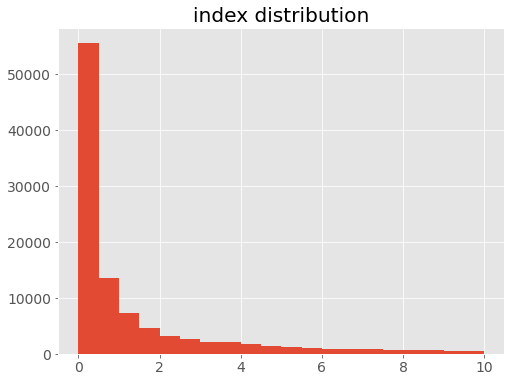

In [22]:
plt.hist(valid_eth_to_stable_index_df['eth_to_stablecoin_ratio'],bins=20,range=[0,10])
plt.title('index distribution')

this looks like a power law.. most values lie under the 0-0.5 interval and then it drops exponentially.

Let's cut on a specific date and see the distribution

Text(0.5, 1.0, 'distribution of index')

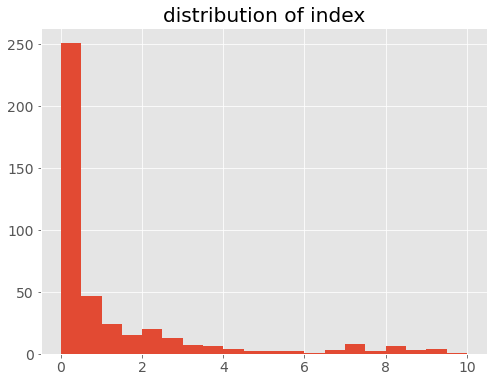

In [23]:
import datetime
valid_eth_to_stable_index_df[valid_eth_to_stable_index_df['date']==datetime.date(2021,9,19)]['eth_to_stablecoin_ratio'].hist(bins=20,range=[0,10])
plt.title('distribution of index')

Let's see top 10 - bottom 10 to get a better sense of their parameters

In [24]:
valid_eth_to_stable_index_df[valid_eth_to_stable_index_df['date']==datetime.date(2021,9,19)].sort_values('eth_to_stablecoin_ratio').head(10)

,address,date,stablecoin_usd_balance,eth_usd_balance,eth_to_stablecoin_ratio
27313,0xcf407e4a4ff843859c41093a6d685f332fedfe15,2021-09-19,500.000000,8.929891e+06,5.59917e-05
107493,0x0d24f692c05036602076b3f51242b5a34c55ee38,2021-09-19,153.509705,2.332555e+06,6.58118e-05
26300,0x60002173b8c04e143ec6297c88e11e3025ef2254,2021-09-19,166.574412,9.841896e+05,0.00016925
94978,0x22fa8cc33a42320385cbd3690ed60a021891cb32,2021-09-19,1762.613337,9.093480e+06,0.000193833
73536,0x00f282c40b92bed05f1776cadf1c8b96b9fbaee3,2021-09-19,1241.417866,5.413296e+06,0.000229328
79060,0xcb33844b365c53d3462271cee9b719b6fc8ba06a,2021-09-19,1148.305385,3.578497e+06,0.00032089
26963,0x7b23e38fbd0e677a1d1f72fe29a1aea9fd83ade8,2021-09-19,623.035239,1.408085e+06,0.00044247
22566,0x5f681ad96ce4ad8b3d7d745ba1e34109afebdab8,2021-09-19,100.000000,1.904660e+05,0.000525028
107635,0x716034c25d9fb4b38c837afe417b7f2b9af3e9ae,2021-09-19,3227.000111,4.011288e+06,0.00080448
36796,0x775d90be88bfc66aba77a551d489e43ce5a33112,2021-09-19,6213.907928,6.110440e+06,0.00101693


In [25]:
valid_eth_to_stable_index_df[valid_eth_to_stable_index_df['date']==datetime.date(2021,9,19)].sort_values('eth_to_stablecoin_ratio',ascending=False).head(10)

,address,date,stablecoin_usd_balance,eth_usd_balance,eth_to_stablecoin_ratio
20465,0x0b4928839e6b77c3e162c67dbd4474574cac21ba,2021-09-19,2.118060e+06,514.587122,4116.04
70673,0xbeb90b87629892a9fe9d47df81b2f87ab7a9ba8f,2021-09-19,3.984264e+05,135.475606,2940.95
31835,0xdb7030beb1c07668aa49ea32fbe0282fe8e9d12f,2021-09-19,9.999983e+06,18249.297446,547.965
96413,0x02c5c20c7aa2725dd244e3deb4bb3435e91e1d68,2021-09-19,2.826744e+05,759.694774,372.089
94538,0x68af1f3f341a1e690d16e0b03f516866093972fd,2021-09-19,1.057949e+05,340.397297,310.798
26918,0x2bd7d71390ed6946159b1cb49bc270cbe3ef1a53,2021-09-19,6.488113e+04,255.410278,254.027
48531,0xa42830ee059c77caf8c8200b44aa9813cb0720c5,2021-09-19,3.437409e+05,1489.387075,230.794
30102,0xfb7e3844348dc2eb31ec32f91aaa82fe5b7b2d71,2021-09-19,4.000000e+04,238.155128,167.958
84386,0xcae2d5aed9f5e0075d49a4b5f492b4a73a64dc25,2021-09-19,6.093164e+04,379.398242,160.601
114231,0xdca313c4df33c2142b2adf202d6abf4fa56e1d41,2021-09-19,1.048991e+06,7763.581479,135.117


At high (>100) or  low (<0.001) values of  **eth_to_stablecoin_ratio** I found very imbalanced wallets either with a lot of ETH or a lot of stablecoins. Either case they look like *whales* holding a lot of value in assets. 

this means the index probably won't work well on this range because whales might behave very differently. 

Text(0.5, 1.0, 'distribution of index for snapshot')

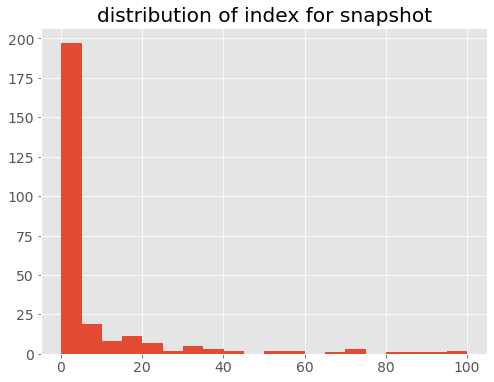

In [28]:
condition = (valid_eth_to_stable_index_df['date']==datetime.date(2021,5,19)) & (valid_eth_to_stable_index_df['eth_to_stablecoin_ratio']>0.1) & (valid_eth_to_stable_index_df['eth_to_stablecoin_ratio']<100)
valid_eth_to_stable_index_df[condition]['eth_to_stablecoin_ratio'].hist(bins=20,range=[0.1,100])
plt.title('distribution of index for snapshot')

Still under this range we find the distribution to be skewed. Looks like its more frequent to have eth>>stable than the other way around. 

Let's track the index across time for a couple of addresses:

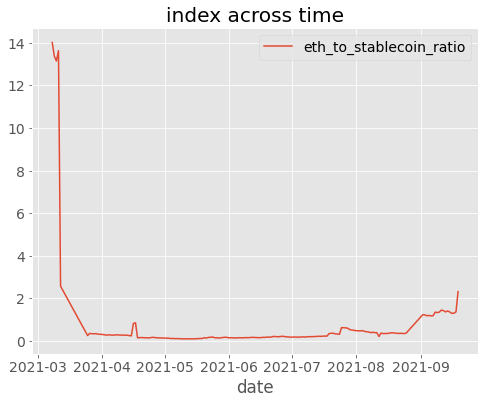

In [29]:
valid_eth_to_stable_index_df[valid_eth_to_stable_index_df['address']==sample_address].sort_values(by='date').plot(x='date',y='eth_to_stablecoin_ratio',title='index across time')

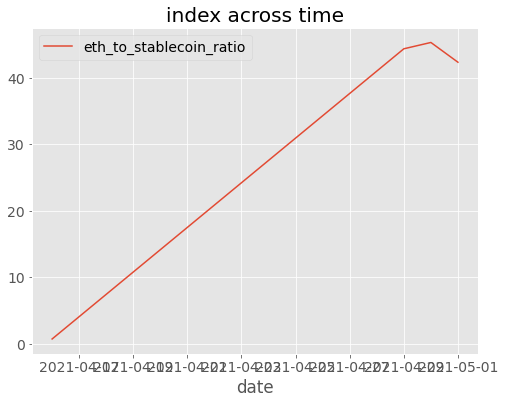

In [30]:
valid_eth_to_stable_index_df[valid_eth_to_stable_index_df['address']=='0xc124e47aa04fa869aa4a2f6fcef717b709562dba'].sort_values(by='date').plot(x='date',y='eth_to_stablecoin_ratio',title='index across time')

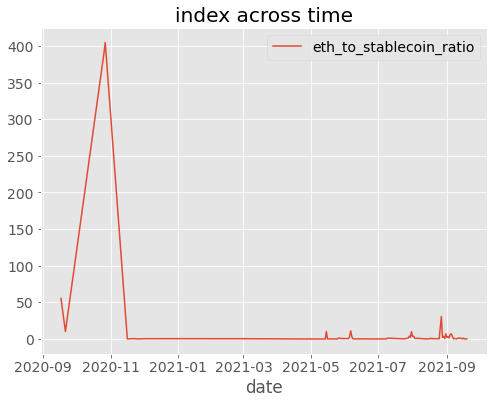

In [31]:
valid_eth_to_stable_index_df[valid_eth_to_stable_index_df['address']=='0x40c839b831c90173dc7fbce49a25274a4688ddd9'].sort_values(by='date').plot(x='date',y='eth_to_stablecoin_ratio',title='index across time')

* might these charts reflect a particular strategy?
* are addresses that mantain a particular ratio across time more trustable?
* there are probably more features to be derived from aggregating this index across different time windows.

# use case

We'll measure the index at the time of the borrow events and explore its distribution for the liquidated vs no liquidated wallets.

* for addresses with liquidation events, we pick the last borrow.
* for addresses with no liquidations so far, we pick the last borrow as well.

In [32]:
join_eth_to_stable_ratio = '''with last_borrow_compound as (
    SELECT *,row_number() over( partition by borrower order by block_timestamp desc) as rank FROM `arcx_dev.compound_usdc_sample_address` 
)
select * from last_borrow_compound 
inner join `arcx_dev.eth_to_stable_index` eth_ratio 
on eth_ratio.address=last_borrow_compound.borrower and eth_ratio.date=cast(last_borrow_compound.block_timestamp as date)
where rank=1
order by block_timestamp desc
'''

eth_to_stable_df = client.query(join_eth_to_stable_ratio).to_dataframe()

In [33]:
eth_to_stable_df

,block_timestamp,block_number,transaction_hash,log_index,contract_address,borrower,borrowAmount,accountBorrows,totalBorrows,has_liquidate_event,rk,rank,address,date,stablecoin_usd_balance,eth_usd_balance,eth_to_stablecoin_ratio
0,2021-09-19 22:05:22+00:00,13258798,0xc7cc6954400cb92e879f464fd16793e6bae4ecd14f3b...,120,0x39aa39c021dfbae8fac545936693ac917d5e7563,0x9c92d74ae777fa12715f0033ba027ecb86bbff6a,20000000,20000000,3600312935234503,0,1,1,0x9c92d74ae777fa12715f0033ba027ecb86bbff6a,2021-09-19,427.920813,184.945356,2.313769
1,2021-09-19 19:52:29+00:00,13258172,0xac5b3dbbbf507413db16d4ca3fb44e978a031f2dc60a...,471,0x39aa39c021dfbae8fac545936693ac917d5e7563,0x8b51980087898a3882f9e46ebe83bb600e4c8e8e,10000000000,97058154070,3600421141098809,0,1,1,0x8b51980087898a3882f9e46ebe83bb600e4c8e8e,2021-09-19,0,261.167656,NaN
2,2021-09-19 18:43:39+00:00,13257838,0x58f3e8e3dc7265db2a8f7d973800bcfeb238beffed7b...,158,0x39aa39c021dfbae8fac545936693ac917d5e7563,0x41d5c91836cb9fbbb644c30ac4278befec52caee,217417521900,1213956014857,3600467814671001,0,1,1,0x41d5c91836cb9fbbb644c30ac4278befec52caee,2021-09-19,17407.5219,205.364294,84.764112
3,2021-09-19 17:17:53+00:00,13257471,0x56eac66a66985d0e9ad932f0e2100bee480fb39ad3fd...,27,0x39aa39c021dfbae8fac545936693ac917d5e7563,0x40c839b831c90173dc7fbce49a25274a4688ddd9,460000000000,671219728319,3600395811760379,0,1,1,0x40c839b831c90173dc7fbce49a25274a4688ddd9,2021-09-19,7084.536606,345601.794356,0.020499
4,2021-09-19 10:18:42+00:00,13255559,0x15f773aef14ed49807e7b45521337333e9faa6adc75c...,429,0x39aa39c021dfbae8fac545936693ac917d5e7563,0x0047db03e71ec758fbf227ed601bae2564eec23b,15000000000,60338462292,3603489706981509,0,1,1,0x0047db03e71ec758fbf227ed601bae2564eec23b,2021-09-19,0,3.399332,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2985,2021-05-01 02:46:17+00:00,12345678,0x7d804518ec6ac0b204fb79ca46c365f91822fbb5caef...,359,0x39aa39c021dfbae8fac545936693ac917d5e7563,0x6aa8d6c337000bb93abff3ef852336c1c1df39d8,3000000000,8047975525,3518864587675676,0,1,1,0x6aa8d6c337000bb93abff3ef852336c1c1df39d8,2021-05-01,0,0.000000,NaN
2986,2021-05-01 01:33:02+00:00,12345376,0xa52f71ea984f6767b19ad527c77f03b4189c5a0c7555...,323,0x39aa39c021dfbae8fac545936693ac917d5e7563,0x34c02997bf359e0e17f8221295c0bb09c2e2346c,749330162,749330162,3519503456244520,1,1,1,0x34c02997bf359e0e17f8221295c0bb09c2e2346c,2021-05-01,0,124.896170,NaN
2987,2021-05-01 01:09:15+00:00,12345277,0x1dfcdd7bc99899bf65e13cab808a9523599afabc365b...,30,0x39aa39c021dfbae8fac545936693ac917d5e7563,0x6513b81d8240cb94abc089f2cba60be6fda2f805,400000000000,809783904803,3519932624642296,0,1,1,0x6513b81d8240cb94abc089f2cba60be6fda2f805,2021-05-01,0,4671.965313,NaN
2988,2021-05-01 00:52:48+00:00,12345188,0x2d1a582ce31928e372229f1b56aa4cb5a449f9629cdb...,330,0x39aa39c021dfbae8fac545936693ac917d5e7563,0xc124e47aa04fa869aa4a2f6fcef717b709562dba,1563705236,56913761541,3519526695814557,0,1,1,0xc124e47aa04fa869aa4a2f6fcef717b709562dba,2021-05-01,54341.852494025,1283.257234,42.346812


In [34]:
# remove invalid ranges
condition = (eth_to_stable_df['eth_to_stablecoin_ratio']>0.01) & (eth_to_stable_df['eth_to_stablecoin_ratio']<50)
valid_eth_to_stable_df = eth_to_stable_df[condition]

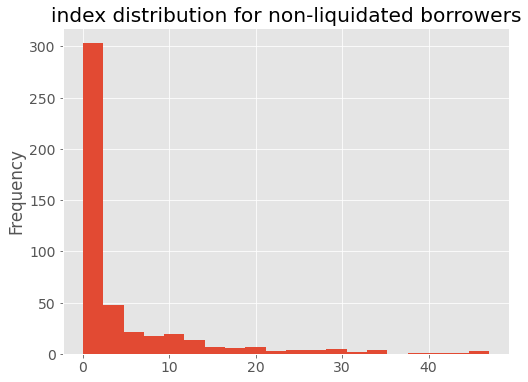

In [35]:
valid_eth_to_stable_df[valid_eth_to_stable_df['has_liquidate_event']==0]['eth_to_stablecoin_ratio'].plot(kind='hist',bins=20,title='index distribution for non-liquidated borrowers')

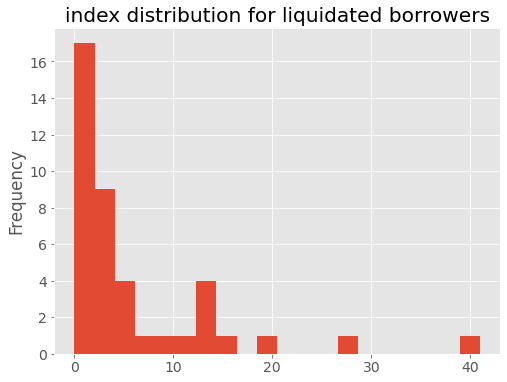

In [36]:
valid_eth_to_stable_df[valid_eth_to_stable_df['has_liquidate_event']==1]['eth_to_stablecoin_ratio'].plot(kind='hist',bins=20,title='index distribution for liquidated borrowers')

In [37]:
eth_to_stable_df.groupby('has_liquidate_event')['eth_to_stablecoin_ratio'].describe()

,count,mean,std,min,25%,50%,75%,max
has_liquidate_event,,,,,,,,
0,523.0,21.919304,144.951326,0.000049,0.218422,1.165447,7.349181,2977.729242
1,44.0,11.220255,22.249409,0.017036,1.192814,2.964638,11.671348,114.298733


In [38]:
valid_eth_to_stable_df.groupby('has_liquidate_event')['eth_to_stablecoin_ratio'].describe()

,count,mean,std,min,25%,50%,75%,max
has_liquidate_event,,,,,,,,
0,469.0,4.686708,8.253724,0.010815,0.229171,1.031879,4.731206,46.978196
1,41.0,5.917953,8.319865,0.017036,0.931623,2.457025,7.512236,40.973427


 ## observations
 * both index distributions for liquidated vs non-liquidated look similar 
 * sample size for liquidated events is low when considering ETH and stablecoin thresholds. 
 * with this setup the index is highly skewed and clusters a lot of addresses within the 0-1 range, some transformations might help. 

# conclusions

* An index was created using Stablecoin balances (usdc+dai+usdt) and ETH balances over time for a given sample of addresses.
* To remove complexity and corner cases, we established arbitrary boundaries for the index to work i.e. the index doesn`t apply when ETH_USD or STABLE_USD <100. 
* We detected outliers matched to wallets holding a lot of usd_value 
* We sampled the index for wallets interacting with the Compound protocol and try to distinguish addresses which had / had not liquidation events. 
